In [37]:
# Data manipulations
import numpy as np
import pandas as pd
import time
# Data transformation, models, scores
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt


In [42]:
# Download file and load into the notebook.
# Original file can be found here: https://www.kaggle.com/harlfoxem/housesalesprediction?select=kc_house_data.csv 
df = pd.read_csv("./data/kc_house_data.csv")

# General data preparation - Out of scope of this post.
# We should ensure that:
# All numberical columns have type: - int or float
# All categorical: - object or category
df['age'] = df['date'].map(lambda x: int(x[:4])) - df['yr_built']
df["renovation"] = df["yr_renovated"].map(lambda x : 1 if x>0 else 0).astype("object")
df["basement"] = df["sqft_basement"].map(lambda x : 1 if x>0 else 0).astype("object")
df["zipcode"] = df["zipcode"].astype("object")
columns_drop_prepare = ["id", "date", "bedrooms", "bathrooms", "floors", "sqft_above", "sqft_basement", "yr_built", "yr_renovated", "lat", "long"]
df_fin = df.drop(columns_drop_prepare, axis = 1)
print(df_fin.info())
df_fin.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   sqft_living    21613 non-null  int64  
 2   sqft_lot       21613 non-null  int64  
 3   waterfront     21613 non-null  int64  
 4   view           21613 non-null  int64  
 5   condition      21613 non-null  int64  
 6   grade          21613 non-null  int64  
 7   zipcode        21613 non-null  object 
 8   sqft_living15  21613 non-null  int64  
 9   sqft_lot15     21613 non-null  int64  
 10  age            21613 non-null  int64  
 11  renovation     21613 non-null  object 
 12  basement       21613 non-null  object 
dtypes: float64(1), int64(9), object(3)
memory usage: 2.1+ MB
None


,price,sqft_living,sqft_lot,waterfront,view,condition,grade,zipcode,sqft_living15,sqft_lot15,age,renovation,basement
0,221900.0,1180,5650,0,0,3,7,98178,1340,5650,59,0,0
1,538000.0,2570,7242,0,0,3,7,98125,1690,7639,63,1,1
2,180000.0,770,10000,0,0,3,6,98028,2720,8062,82,0,0
3,604000.0,1960,5000,0,0,5,7,98136,1360,5000,49,0,1
4,510000.0,1680,8080,0,0,3,8,98074,1800,7503,28,0,0


In [22]:
def linear_reg_calculator(Data, dependent,  n = 1, model_input = LinearRegression(), graph = False, table_results = None, graph_size = 2000):
    
    # Initialize basic transformation functions. 
    kf = KFold(5)
    encoder = OneHotEncoder(handle_unknown='ignore', drop = "first")
    scaler = StandardScaler()
    poly = PolynomialFeatures(degree = n)
    output_report = ["Model","Poly degree", "Train R2", "Train RMSE", "Test mean R2", "Test mean RMSE", "Execution time, sec"]
    
    # Add reset function to our DataFrame
    if table_results is None:
        output = pd.DataFrame(columns = output_report)
    else:
        output = table_results
        
    # Define function for variable transformations:
    def transformation(X_train, X_test):
        
        # Numerical transformation
        X_train_num = X_train.select_dtypes(include = np.number)
        X_test_num = X_test.select_dtypes(include = np.number)
        scaler.fit(X_train_num) # Train scaler transformer
        poly.fit(X_train_num)   # Train ploynomial transformer
        
        # Apply scaler to numerical train and test columns.
        # And Recreate dataframe with new data.
        X_train_num_ss = pd.DataFrame(data = scaler.transform(X_train_num), index = X_train_num.index, 
                                      columns = scaler.get_feature_names_out())
        X_test_num_ss = pd.DataFrame(data = scaler.transform(X_test_num), index = X_test_num.index, 
                                      columns = scaler.get_feature_names_out())
        
        # Apply ploynomial to numerical train and test columns.
        # And Recreate dataframe with new data.
        X_train_num_ss_poly = pd.DataFrame(data = poly.transform(X_train_num_ss), index = X_train_num.index, 
                                       columns = poly.get_feature_names_out())
        X_test_num_ss_poly = pd.DataFrame(data = poly.transform(X_test_num_ss), index = X_test_num.index, 
                                       columns = poly.get_feature_names_out())

        # Categorical transformation
        X_train_cat = X_train.select_dtypes(include = [object, 'category'])
        X_test_cat = X_test.select_dtypes(include = [object, 'category'])
        encoder.fit(X_train_cat) # Train categorical transformer on train data
        
        # Apply categorical tranformer to categorical train and test columns.
        # And Recreate dataframe with new data.
        X_train_cat_encoded = pd.DataFrame(data = encoder.transform(X_train_cat).todense(), index = X_train_cat.index, 
                                           columns = encoder.get_feature_names_out())
        X_test_cat_encoded = pd.DataFrame(data = encoder.transform(X_test_cat).todense(), index = X_test_cat.index, 
                                           columns = encoder.get_feature_names_out())
        
        # Combine numerical and categorial columns
        X_train = pd.concat([X_train_num_ss_poly, X_train_cat_encoded], axis = 1)
        X_test = pd.concat([X_test_num_ss_poly, X_test_cat_encoded], axis = 1)
        
        return X_train, X_test
    
  
    # Define our independent in dependent variables:
    X = Data.drop(dependent, axis = 1)
    y = Data[dependent]
    
    
    # Put timer at the beginning
    start = time.time()
    
    # Perform 5 - kfold splits with 
    r2_train_list = []
    r2_test_list = []
    RMSE_train_list = []
    RMSE_test_list = []

    
    # Perform 5 - kfold splits with 
    for train_index, test_index in kf.split(X): #We defined kf before. 
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        
        # Data transormation based on previous function
        X_train, X_test = transformation(X_train, X_test)
        
        #Modeling
        model = model_input          # Define our model based on function inputs
        model.fit(X_train, y_train)  # Train the model based on train data. 
        y_train_hat = model.predict(X_train)  # Predict Y train
        y_test_hat = model.predict(X_test)    # Preduct Y test
        
        #Calculate scores
        RMSE_train = mean_squared_error(y_train, y_train_hat, squared = False)
        RMSE_test = mean_squared_error(y_test, y_test_hat, squared = False)
        r2_train = r2_score(y_train, y_train_hat)
        r2_test = r2_score(y_test, y_test_hat)
        
        #Add scores for each split into overall list of scores
        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)
        RMSE_train_list.append(RMSE_train)
        RMSE_test_list.append(RMSE_test)
    
    # Find mean values and standard deviation of test scores.
    r2_train_mean = np.mean(r2_train_list)
    r2_test_mean = np.mean(r2_test_list)
    r2_test_std = np.std(r2_test_list)
    RMSE_train_mean = np.mean(RMSE_train_list)
    RMSE_test_mean = np.mean(RMSE_test_list)
    RMSE_test_std = np.std(RMSE_test_list)

    
    
    #Graph
    if graph:
        y_hat = np.concatenate([y_train_hat, y_test_hat], axis = 0)
        # For better visual representation we will take a sample from our dataset
        index_sample = X.sample(n = graph_size).index 
        y_sample = y.iloc[index_sample]
        y_hat_sample = y_hat[index_sample]
        #We will make a custom plot grid for better visual representation 
        gs_kw = dict(width_ratios=[3,3,1])
        fig, (left_axs, central_axs, right_axs) = plt.subplots(1, 3, figsize = (15, 4), constrained_layout=True,
        gridspec_kw=gs_kw)
        # Central plot
        x_axis = y_sample # actual price
        y_axis = ((y_hat_sample-y_sample)/y_sample) # % error
        central_axs.scatter(x_axis, y_axis, s=.4, alpha=1, color = "r")
        central_axs.set(xlim=(0, 2000000), ylim=(-1, 1), xlabel='Price of the house', ylabel='Error term', title='Errors vs house prices');
        # Left plot
        x_line = np.linspace(0,2000000)
        left_axs.scatter(y_sample, y_hat_sample, marker =".",s=.4, alpha=1, color = "r")
        left_axs.plot(x_line, x_line, color ="red", label = "Ideal prediction line") 
        left_axs.set(xlim=(0, 2000000), ylim=(0,2000000), xlabel='Price of the house', ylabel='Predicted price', title='Real vs Predicted house prices');
        # Right plot
        sns.scatterplot(data= r2_test_list,  ax = right_axs)
        sns.violinplot(data= r2_test_list,  ax = right_axs, inner="points", color="grey")
        right_axs.set(xlabel='R2 results', ylabel='value', title='R2 results distribution');
    
    #Outputs
    end = time.time() # End of timer
    print(f"Model: {model}") 
    print(f"Variance explained by model (R^2 Score): {round(r2_test_mean*100,1)}% with stadard deviation {round(r2_test_std*100,1)}%")
    print(f"Root Mean Squared Error: {RMSE_test_mean}")
    
    # Create Dataframe from our results and add them to our results DataFrame. 
    line = pd.DataFrame(data = [[model, n, r2_train_mean, RMSE_train_mean, r2_test_mean, RMSE_test_mean, round(end-start, 2)]], columns = output_report)
    output= pd.concat([output, line])
    return output
        
    

Model: LinearRegression()
Variance explained by model (R^2 Score): 80.0% with stadard deviation 1.3%
Root Mean Squared Error: 164092.94515153422


,Model,Poly degree,Train R2,Train RMSE,Test mean R2,Test mean RMSE,"Execution time, sec"
0,LinearRegression(),1,0.803835,162582.681298,0.79955,164092.945152,0.73


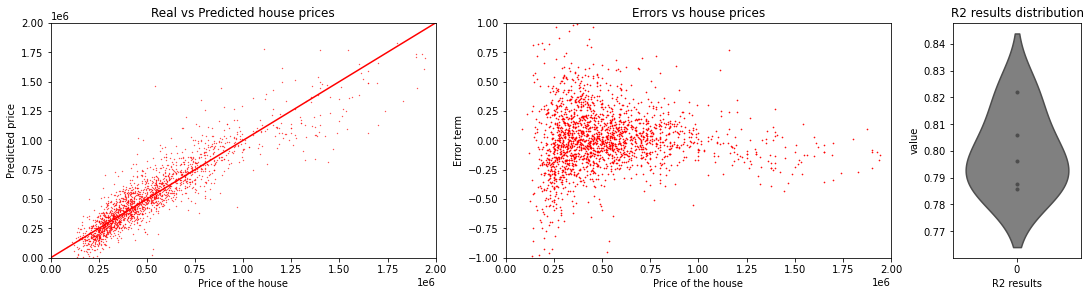

In [41]:
dependent = "price"
model = LinearRegression()
results = linear_reg_calculator(df_fin, dependent, n=1, model_input =  model, graph = True, table_results = None)
results

In [24]:
results

,Model,Poly degree,Train R2,Train RMSE,Test mean R2,Test mean RMSE,"Execution time, sec"
0,LinearRegression(),2,0.864903,134912.066058,0.853992,139902.913155,1.05


In [40]:
model_list = [LinearRegression(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor(max_leaf_nodes = 50, n_estimators = 10)]
powers_list = [1,2]
dependent = "price"
result = pd.DataFrame()
for model in model_list:
    for power in powers_list:
        result = linear_reg_calculator(df_fin, dependent, n=power, model_input =  model, graph = False, table_results = result)
result
    
    

Model: LinearRegression()
Variance explained by model (R^2 Score): 80.0% with stadard deviation 1.3%
Root Mean Squared Error: 164092.94515153422
Model: LinearRegression()
Variance explained by model (R^2 Score): 85.4% with stadard deviation 1.0%
Root Mean Squared Error: 139902.91315507246
Model: Ridge()
Variance explained by model (R^2 Score): 79.9% with stadard deviation 1.3%
Root Mean Squared Error: 164166.37344526732
Model: Ridge()
Variance explained by model (R^2 Score): 85.4% with stadard deviation 1.0%
Root Mean Squared Error: 139974.59025883657
Model: DecisionTreeRegressor()
Variance explained by model (R^2 Score): 66.6% with stadard deviation 1.9%
Root Mean Squared Error: 211627.26727689608
Model: DecisionTreeRegressor()
Variance explained by model (R^2 Score): 66.5% with stadard deviation 4.9%
Root Mean Squared Error: 211315.55784763832
Model: RandomForestRegressor(max_leaf_nodes=50, n_estimators=10)
Variance explained by model (R^2 Score): 73.7% with stadard deviation 1.2%
Ro

,Model,Poly degree,Train R2,Train RMSE,Test mean R2,Test mean RMSE,"Execution time, sec"
0,LinearRegression(),1,0.803835,162582.681298,0.799550,164092.945152,0.62
0,LinearRegression(),2,0.864903,134912.066058,0.853992,139902.913155,1.05
0,Ridge(),1,0.803618,162672.525745,0.799377,164166.373445,0.66
0,Ridge(),2,0.864691,135018.193838,0.853840,139974.590259,0.82
0,DecisionTreeRegressor(),1,0.999883,3966.396840,0.665742,211627.267277,2.05
0,DecisionTreeRegressor(),2,0.999883,3966.396840,0.664687,211315.557848,7.99
0,"(DecisionTreeRegressor(max_features='auto', ma...",1,0.786918,169425.034391,0.737394,187678.963849,3.61
0,"(DecisionTreeRegressor(max_features='auto', ma...",2,0.801833,163384.108014,0.740157,186828.929023,15.11
